https://github.com/SakuraRiven/EAST/

https://blog.csdn.net/qq_41576083/article/details/88077185#3.2%20generate_rbox%E6%A0%87%E7%AD%BE%E7%94%9F%E6%88%90

https://shimo.im/docs/pRDd9hddhw9RDWxH/read

# Draw

In [104]:
#coding=utf-8
#python 3
import os
import shutil
import cv2
import numpy as np

root_ = "/home/luoxiaosheng/Downloads/CV_formal/OCR/ICDAR/ch4/"
gt_path = root_ + "ch4_training_gt/"
img_path = root_ + "ch4_training_images/"
root_save = root_ + "ICDAR_with_GT/"
# os.mkdir(root_save)
txt_list = os.listdir(gt_path)

cnt_ = 0    #count
for file_name in txt_list[:1]:
    
    cnt_ += 1
    img_name = file_name.replace('gt_','')
    img_name = img_name.replace('.txt','.jpg')
    print("%d:::%s"%(cnt_,img_name))
    
    path_img = img_path + img_name
    img = cv2.imread(path_img)
    path_txt = gt_path + file_name
    
    #generate 4 pair-points
    with open(path_txt,'r',encoding='utf-8') as f:
        str = f.readlines()
    ll_pt = []
    for path in str:
#         print (path.strip())
        path = path.strip()
        list_str = path.encode('utf-8').decode('utf-8-sig').split(',')
#         print(list_str)
        l_pt = []
        l_pt_tmp = []
        for i in range(0,8):
            l_pt.append(int(list_str[i]))
            if i % 2 != 0:
                l_pt_tmp.append(l_pt)
                l_pt = []
        ll_pt.append(l_pt_tmp)
                 #[[915, 501], [953, 523], [948, 554], [910, 533]]
    ll_pt.append([[921, 514], [942, 527], [940, 539], [919, 527]])    #shrink box
    ll_pt.append([[921., 514.], [934., 493.], [946., 495.], [934., 516.]])   #rotate vertices -90
    ll_pt.append([[921., 514.], [908., 535.], [896., 533.], [908., 512.]])
    print(ll_pt)
    #draw
    for v_pt in ll_pt:
#         print(v_pt)
        point = np.array(v_pt,np.int32)
        cv2.polylines(img, [point], True, (0, 255, 255))

    # cv2.imshow('helo',img)
    # cv2.waitKey(0)
    draw_img_path = root_save + img_name
    cv2.imwrite(draw_img_path,img)


1:::img_489.jpg
[[[915, 501], [953, 523], [948, 554], [910, 533]], [[870, 491], [1025, 583], [1010, 635], [855, 544]], [[921, 514], [942, 527], [940, 539], [919, 527]], [[921.0, 514.0], [934.0, 493.0], [946.0, 495.0], [934.0, 516.0]], [[921.0, 514.0], [908.0, 535.0], [896.0, 533.0], [908.0, 512.0]]]


# dataset.py

In [2]:
from shapely.geometry import Polygon
import numpy as np
import cv2
from PIL import Image
import math
import os
import torch
import torchvision.transforms as transforms
from torch.utils import data

In [3]:
def cal_distance(x1, y1, x2, y2):
    '''calculate the Euclidean distance'''
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

def move_points(vertices, index1, index2, r, coef):
    '''move the two points to shrink edge
    Input:
        vertices: vertices of text region <numpy.ndarray, (8,)>
        index1  : offset of point1
        index2  : offset of point2
        r       : [r1, r2, r3, r4] in paper
        coef    : shrink ratio in paper
    Output:
        vertices: vertices where one edge has been shinked
    '''
    index1 = index1 % 4
    index2 = index2 % 4
    x1_index = index1 * 2 + 0
    y1_index = index1 * 2 + 1
    x2_index = index2 * 2 + 0
    y2_index = index2 * 2 + 1

    r1 = r[index1]
    r2 = r[index2]
    length_x = vertices[x1_index] - vertices[x2_index]
    length_y = vertices[y1_index] - vertices[y2_index]
    length = cal_distance(vertices[x1_index], vertices[y1_index], vertices[x2_index], vertices[y2_index])
    if length > 1:
        ratio = (r1 * coef) / length
        vertices[x1_index] += ratio * (-length_x) 
        vertices[y1_index] += ratio * (-length_y) 
        ratio = (r2 * coef) / length
        vertices[x2_index] += ratio * length_x 
        vertices[y2_index] += ratio * length_y
    return vertices

def shrink_poly(vertices, coef=0.3):
    '''shrink the text region
    Input:
        vertices: vertices of text region <numpy.ndarray, (8,)>
        coef    : shrink ratio in paper
    Output:
        v       : vertices of shrinked text region <numpy.ndarray, (8,)>
    '''
    x1, y1, x2, y2, x3, y3, x4, y4 = vertices
    r1 = min(cal_distance(x1,y1,x2,y2), cal_distance(x1,y1,x4,y4))
    r2 = min(cal_distance(x2,y2,x1,y1), cal_distance(x2,y2,x3,y3))
    r3 = min(cal_distance(x3,y3,x2,y2), cal_distance(x3,y3,x4,y4))
    r4 = min(cal_distance(x4,y4,x1,y1), cal_distance(x4,y4,x3,y3))
    r = [r1, r2, r3, r4]

    # obtain offset to perform move_points() automatically
    if cal_distance(x1,y1,x2,y2) + cal_distance(x3,y3,x4,y4) > \
       cal_distance(x2,y2,x3,y3) + cal_distance(x1,y1,x4,y4):
        offset = 0 # two longer edges are (x1y1-x2y2) & (x3y3-x4y4)
    else:
        offset = 1 # two longer edges are (x2y2-x3y3) & (x4y4-x1y1)

    v = vertices.copy()
    v = move_points(v, 0 + offset, 1 + offset, r, coef)
    v = move_points(v, 2 + offset, 3 + offset, r, coef)
    v = move_points(v, 1 + offset, 2 + offset, r, coef)
    v = move_points(v, 3 + offset, 4 + offset, r, coef)
    return v

In [4]:
def get_boundary(vertices):
    '''get the tight boundary around given vertices
    Input:
        vertices: vertices of text region <numpy.ndarray, (8,)>
    Output:
        the boundary
    '''
    x1, y1, x2, y2, x3, y3, x4, y4 = vertices
    x_min = min(x1, x2, x3, x4)
    x_max = max(x1, x2, x3, x4)
    y_min = min(y1, y2, y3, y4)
    y_max = max(y1, y2, y3, y4)
    return x_min, x_max, y_min, y_max


def cal_error(vertices):
    '''default orientation is x1y1 : left-top, x2y2 : right-top, x3y3 : right-bot, x4y4 : left-bot
    calculate the difference between the vertices orientation and default orientation
    Input:
        vertices: vertices of text region <numpy.ndarray, (8,)>
    Output:
        err     : difference measure
    '''
    x_min, x_max, y_min, y_max = get_boundary(vertices)
    x1, y1, x2, y2, x3, y3, x4, y4 = vertices
    err = cal_distance(x1, y1, x_min, y_min) + cal_distance(x2, y2, x_max, y_min) + \
          cal_distance(x3, y3, x_max, y_max) + cal_distance(x4, y4, x_min, y_max)
    return err

In [134]:
def get_rotate_mat(theta):
    '''positive theta value means rotate clockwise'''
    return np.array([[math.cos(theta), -math.sin(theta)], [math.sin(theta), math.cos(theta)]])


def rotate_vertices(vertices, theta, anchor=None):
    '''rotate vertices around anchor
    Input:
        vertices: vertices of text region <numpy.ndarray, (8,)>
        theta   : angle in radian measure
        anchor  : fixed position during rotation
    Output:
        rotated vertices <numpy.ndarray, (8,)>
    '''
    v = vertices.reshape((4,2)).T
    if anchor is None:
        anchor = v[:,:1]    #pin the first point
    rotate_mat = get_rotate_mat(theta)
    res = np.dot(rotate_mat, v - anchor)
    return (res + anchor).T.reshape(-1)


def rotate_img(img, vertices, angle_range=10):
    '''rotate image [-10, 10] degree to aug data
    Input:
        img         : PIL Image
        vertices    : vertices of text regions <numpy.ndarray, (n,8)>
        angle_range : rotate range
    Output:
        img         : rotated PIL Image
        new_vertices: rotated vertices
    '''
    center_x = (img.width - 1) / 2
    center_y = (img.height - 1) / 2
    angle = angle_range * (np.random.rand() * 2 - 1)
    img = img.rotate(angle, Image.BILINEAR)
    new_vertices = np.zeros(vertices.shape)
    for i, vertice in enumerate(vertices):
        new_vertices[i,:] = rotate_vertices(vertice, -angle / 180 * math.pi, np.array([[center_x],[center_y]]))
    return img, new_vertices


def rotate_all_pixels(rotate_mat, anchor_x, anchor_y, length):
    '''get rotated locations of all pixels for next stages
    Input:
        rotate_mat: rotatation matrix
        anchor_x  : fixed x position
        anchor_y  : fixed y position
        length    : length of image
    Output:
        rotated_x : rotated x positions <numpy.ndarray, (length,length)>
        rotated_y : rotated y positions <numpy.ndarray, (length,length)>
    '''
    x = np.arange(length)
    y = np.arange(length)
    x, y = np.meshgrid(x, y)
    x_lin = x.reshape((1, x.size))
    y_lin = y.reshape((1, x.size))
    coord_mat = np.concatenate((x_lin, y_lin), 0)
    rotated_coord = np.dot(rotate_mat, coord_mat - np.array([[anchor_x], [anchor_y]])) + \
                                                   np.array([[anchor_x], [anchor_y]])
    rotated_x = rotated_coord[0, :].reshape(x.shape)
    rotated_y = rotated_coord[1, :].reshape(y.shape)
    return rotated_x, rotated_y

In [135]:
def find_min_rect_angle(vertices):
    '''find the best angle to rotate poly and obtain min rectangle
    Input:
        vertices: vertices of text region <numpy.ndarray, (8,)>
    Output:
        the best angle <radian measure>
    '''
    angle_interval = 1
    angle_list = list(range(-90, 90, angle_interval))
    area_list = []
    for theta in angle_list: 
        rotated = rotate_vertices(vertices, theta / 180 * math.pi)    #角度=180°×弧度÷π, 弧度=角度×π÷180°
        x1, y1, x2, y2, x3, y3, x4, y4 = rotated
        temp_area = (max(x1, x2, x3, x4) - min(x1, x2, x3, x4)) * \
                    (max(y1, y2, y3, y4) - min(y1, y2, y3, y4))
        area_list.append(temp_area)

    sorted_area_index = sorted(list(range(len(area_list))), key=lambda k : area_list[k])    #升序

    min_error = float('inf')
    best_index = -1
    rank_num = 10
    # find the best angle with correct orientation
    for index in sorted_area_index[:rank_num]:
        rotated = rotate_vertices(vertices, angle_list[index] / 180 * math.pi)
        temp_error = cal_error(rotated)
        if temp_error < min_error:
            min_error = temp_error
            best_index = index
    return angle_list[best_index] / 180 * math.pi

In [136]:
def is_cross_text(start_loc, length, vertices):
    '''check if the crop image crosses text regions
    Input:
        start_loc: left-top position
        length   : length of crop image
        vertices : vertices of text regions <numpy.ndarray, (n,8)>
    Output:
        True if crop image crosses text region
    '''
    if vertices.size == 0:
        return False
    start_w, start_h = start_loc
    a = np.array([start_w, start_h, start_w + length, start_h, \
          start_w + length, start_h + length, start_w, start_h + length]).reshape((4,2))
    p1 = Polygon(a).convex_hull
    for vertice in vertices:
        p2 = Polygon(vertice.reshape((4,2))).convex_hull
        inter = p1.intersection(p2).area
        if 0.01 <= inter / p2.area <= 0.99: 
            return True
    return False


def crop_img(img, vertices, labels, length):
    '''crop img patches to obtain batch and augment
    Input:
        img         : PIL Image
        vertices    : vertices of text regions <numpy.ndarray, (n,8)>
        labels      : 1->valid, 0->ignore, <numpy.ndarray, (n,)>
        length      : length of cropped image region
    Output:
        region      : cropped image region
        new_vertices: new vertices in cropped region
    '''
    h, w = img.height, img.width
    # confirm the shortest side of image >= length
    if h >= w and w < length:
        img = img.resize((length, int(h * length / w)), Image.BILINEAR)
    elif h < w and h < length:
        img = img.resize((int(w * length / h), length), Image.BILINEAR)
    ratio_w = img.width / w
    ratio_h = img.height / h
    assert(ratio_w >= 1 and ratio_h >= 1)

    new_vertices = np.zeros(vertices.shape)
    if vertices.size > 0:
        new_vertices[:,[0,2,4,6]] = vertices[:,[0,2,4,6]] * ratio_w
        new_vertices[:,[1,3,5,7]] = vertices[:,[1,3,5,7]] * ratio_h

    # find random position
    remain_h = img.height - length
    remain_w = img.width - length
    flag = True
    cnt = 0
    while flag and cnt < 1000:
        cnt += 1
        start_w = int(np.random.rand() * remain_w)
        start_h = int(np.random.rand() * remain_h)
        flag = is_cross_text([start_w, start_h], length, new_vertices[labels==1,:])
    box = (start_w, start_h, start_w + length, start_h + length)
    region = img.crop(box)
    if new_vertices.size == 0:
        return region, new_vertices

    new_vertices[:,[0,2,4,6]] -= start_w
    new_vertices[:,[1,3,5,7]] -= start_h
    return region, new_vertices

In [137]:
def extract_vertices(lines):
    '''extract vertices info from txt lines
    Input:
        lines   : list of string info
    Output:
        vertices: vertices of text regions <numpy.ndarray, (n,8)>
        labels  : 1->valid, 0->ignore, <numpy.ndarray, (n,)>
    '''
    labels = []
    vertices = []
    for line in lines:
        vertices.append(list(map(int,line.rstrip('\n').lstrip('\ufeff').split(',')[:8])))
        label = 0 if '###' in line else 1
        labels.append(label)
    return np.array(vertices), np.array(labels)

In [138]:
def adjust_height(img, vertices, ratio=0.2):
    '''adjust height of image to aug data
    Input:
        img         : PIL Image
        vertices    : vertices of text regions <numpy.ndarray, (n,8)>
        ratio       : height changes in [0.8, 1.2]
    Output:
        img         : adjusted PIL Image
        new_vertices: adjusted vertices
    '''
    ratio_h = 1 + ratio * (np.random.rand() * 2 - 1)
    old_h = img.height
    new_h = int(np.around(old_h * ratio_h))
    img = img.resize((img.width, new_h), Image.BILINEAR)

    new_vertices = vertices.copy()
    if vertices.size > 0:
        new_vertices[:,[1,3,5,7]] = vertices[:,[1,3,5,7]] * (new_h / old_h)
    return img, new_vertices

In [139]:
def get_score_geo(img, vertices, labels, scale, length):
    '''generate score gt and geometry gt
    Input:
        img     : PIL Image
        vertices: vertices of text regions <numpy.ndarray, (n,8)>
        labels  : 1->valid, 0->ignore, <numpy.ndarray, (n,)>
        scale   : feature map / image
        length  : image length
    Output:
        score gt, geo gt, ignored
    '''
    score_map   = np.zeros((int(img.height * scale), int(img.width * scale), 1), np.float32)
    geo_map     = np.zeros((int(img.height * scale), int(img.width * scale), 5), np.float32)
    ignored_map = np.zeros((int(img.height * scale), int(img.width * scale), 1), np.float32)

    index = np.arange(0, length, int(1/scale))
    index_x, index_y = np.meshgrid(index, index)
    
    ignored_polys = []    #vertices with label '###'
    polys = []            #vertices with word label

    for i, vertice in enumerate(vertices):
        if labels[i] == 0: 
            ignored_polys.append(np.around(scale * vertice.reshape((4,2))).astype(np.int32))
            continue

        poly = np.around(scale * shrink_poly(vertice).reshape((4,2))).astype(np.int32) # scaled & shrinked
        polys.append(poly)
        temp_mask = np.zeros(score_map.shape[:-1], np.float32)    
        cv2.fillPoly(temp_mask, [poly], 1)    #score_map 0/1

        theta = find_min_rect_angle(vertice)
        rotate_mat = get_rotate_mat(theta)

        rotated_vertices = rotate_vertices(vertice, theta)
        x_min, x_max, y_min, y_max = get_boundary(rotated_vertices)
        rotated_x, rotated_y = rotate_all_pixels(rotate_mat, vertice[0], vertice[1], length)

        d1 = rotated_y - y_min
        d1[d1<0] = 0
        d2 = y_max - rotated_y
        d2[d2<0] = 0
        d3 = rotated_x - x_min
        d3[d3<0] = 0
        d4 = x_max - rotated_x
        d4[d4<0] = 0
        geo_map[:,:,0] += d1[index_y, index_x] * temp_mask
        geo_map[:,:,1] += d2[index_y, index_x] * temp_mask
        geo_map[:,:,2] += d3[index_y, index_x] * temp_mask
        geo_map[:,:,3] += d4[index_y, index_x] * temp_mask
        geo_map[:,:,4] += theta * temp_mask

#     cv2.fillPoly(ignored_map, ignored_polys, 1)
    cv2.fillPoly(score_map, polys, 1)
    return torch.Tensor(score_map).permute(2,0,1), torch.Tensor(geo_map).permute(2,0,1), torch.Tensor(ignored_map).permute(2,0,1)

In [181]:
class custom_dataset(data.Dataset):
    def __init__(self, img_path, gt_path, scale=0.25, length=512):
        super(custom_dataset, self).__init__()
        self.img_files = [os.path.join(img_path, img_file) for img_file in sorted(os.listdir(img_path))]
        self.gt_files  = [os.path.join(gt_path, gt_file) for gt_file in sorted(os.listdir(gt_path))]
        self.scale = scale
        self.length = length

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, index):
        with open(self.gt_files[index], 'r') as f:
            lines = f.readlines()
        vertices, labels = extract_vertices(lines)

        img = Image.open(self.img_files[index])
        img, vertices = adjust_height(img, vertices) 
        img, vertices = rotate_img(img, vertices)
        img, vertices = crop_img(img, vertices, labels, self.length) 
        transform = transforms.Compose([transforms.ColorJitter(0.5, 0.5, 0.5, 0.25), \
                                        transforms.ToTensor(), \
                                        transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))])

        score_map, geo_map, ignored_map = get_score_geo(img, vertices, labels, self.scale, self.length)
        return transform(img), score_map, geo_map, ignored_map

# model.py

In [196]:
import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F
import math


cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


class VGG(nn.Module):
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 1000),
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


class extractor(nn.Module):
    def __init__(self, pretrained):
        super(extractor, self).__init__()
        vgg16_bn = VGG(make_layers(cfg, batch_norm=True))
        if pretrained:
            vgg16_bn.load_state_dict(torch.load('./pths/vgg16_bn-6c64b313.pth'))
        self.features = vgg16_bn.features

    def forward(self, x):
        out = []
        for m in self.features:
            x = m(x)
            if isinstance(m, nn.MaxPool2d):
                out.append(x)
        return out[1:]


class merge(nn.Module):
    def __init__(self):
        super(merge, self).__init__()

        self.conv1 = nn.Conv2d(1024, 128, 1)
        self.bn1 = nn.BatchNorm2d(128)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(384, 64, 1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU()

        self.conv5 = nn.Conv2d(192, 32, 1)
        self.bn5 = nn.BatchNorm2d(32)
        self.relu5 = nn.ReLU()
        self.conv6 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(32)
        self.relu6 = nn.ReLU()

        self.conv7 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(32)
        self.relu7 = nn.ReLU()

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        y = F.interpolate(x[3], scale_factor=2, mode='bilinear', align_corners=True)
        y = torch.cat((y, x[2]), 1)
        y = self.relu1(self.bn1(self.conv1(y)))
        y = self.relu2(self.bn2(self.conv2(y)))

        y = F.interpolate(y, scale_factor=2, mode='bilinear', align_corners=True)
        y = torch.cat((y, x[1]), 1)
        y = self.relu3(self.bn3(self.conv3(y)))
        y = self.relu4(self.bn4(self.conv4(y)))

        y = F.interpolate(y, scale_factor=2, mode='bilinear', align_corners=True)
        y = torch.cat((y, x[0]), 1)
        y = self.relu5(self.bn5(self.conv5(y)))
        y = self.relu6(self.bn6(self.conv6(y)))

        y = self.relu7(self.bn7(self.conv7(y)))
        return y

class output(nn.Module):
    def __init__(self, scope=512):
        super(output, self).__init__()
        self.conv1 = nn.Conv2d(32, 1, 1)
        self.sigmoid1 = nn.Sigmoid()
        self.conv2 = nn.Conv2d(32, 4, 1)
        self.sigmoid2 = nn.Sigmoid()
        self.conv3 = nn.Conv2d(32, 1, 1)
        self.sigmoid3 = nn.Sigmoid()
        self.scope = 512    #trick
        
        #weight initialazation
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        score = self.sigmoid1(self.conv1(x))
        loc   = self.sigmoid2(self.conv2(x)) * self.scope
        angle = (self.sigmoid3(self.conv3(x)) - 0.5) * math.pi
        geo   = torch.cat((loc, angle), 1) 
        return score, geo


class EAST(nn.Module):
    def __init__(self, pretrained=True):
        super(EAST, self).__init__()
        self.extractor = extractor(pretrained)
        self.merge     = merge()
        self.output    = output()

    def forward(self, x):
        return self.output(self.merge(self.extractor(x)))


if __name__ == '__main__':
    m = EAST()
    x = torch.randn(1, 3, 256, 256)
    score, geo = m(x)
    print(score.shape)
    print(geo.shape)

torch.Size([1, 1, 64, 64])
torch.Size([1, 5, 64, 64])


# loss.py

In [198]:
import torch
import torch.nn as nn


def get_dice_loss(gt_score, pred_score):
    inter = torch.sum(gt_score * pred_score)
    union = torch.sum(gt_score) + torch.sum(pred_score) + 1e-5
    return 1. - (2 * inter / union)


def get_geo_loss(gt_geo, pred_geo):
    d1_gt, d2_gt, d3_gt, d4_gt, angle_gt = torch.split(gt_geo, 1, 1)
    d1_pred, d2_pred, d3_pred, d4_pred, angle_pred = torch.split(pred_geo, 1, 1)
    area_gt = (d1_gt + d2_gt) * (d3_gt + d4_gt)
    area_pred = (d1_pred + d2_pred) * (d3_pred + d4_pred)
    w_union = torch.min(d3_gt, d3_pred) + torch.min(d4_gt, d4_pred)
    h_union = torch.min(d1_gt, d1_pred) + torch.min(d2_gt, d2_pred)
    area_intersect = w_union * h_union
    area_union = area_gt + area_pred - area_intersect
    iou_loss_map = -torch.log((area_intersect + 1.0)/(area_union + 1.0))
    angle_loss_map = 1 - torch.cos(angle_pred - angle_gt)
    return iou_loss_map, angle_loss_map


class Loss(nn.Module):
    def __init__(self, weight_angle=10):
        super(Loss, self).__init__()
        self.weight_angle = weight_angle

    def forward(self, gt_score, pred_score, gt_geo, pred_geo, ignored_map):
        if torch.sum(gt_score) < 1:
            return torch.sum(pred_score + pred_geo) * 0

        classify_loss = get_dice_loss(gt_score, pred_score*(1-ignored_map))
        iou_loss_map, angle_loss_map = get_geo_loss(gt_geo, pred_geo)

        angle_loss = torch.sum(angle_loss_map*gt_score) / torch.sum(gt_score)
        iou_loss = torch.sum(iou_loss_map*gt_score) / torch.sum(gt_score)
        geo_loss = self.weight_angle * angle_loss + iou_loss
        print('classify loss is {:.8f}, angle loss is {:.8f}, iou loss is {:.8f}'.format(classify_loss, angle_loss, iou_loss))
        return geo_loss + classify_loss


# train.py

In [199]:
import torch
from torch.utils import data
from torch import nn
from torch.optim import lr_scheduler
from dataset import custom_dataset
from model import EAST
from loss import Loss
import os
import time
import numpy as np


def train(train_img_path, train_gt_path, pths_path, batch_size, lr, num_workers, epoch_iter, interval):
    file_num = len(os.listdir(train_img_path))
    trainset = custom_dataset(train_img_path, train_gt_path)
    train_loader = data.DataLoader(trainset, batch_size=batch_size, \
                                   shuffle=True, num_workers=num_workers, drop_last=True)

    criterion = Loss()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = EAST()
    data_parallel = False
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
        data_parallel = True
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[epoch_iter//2], gamma=0.1)

    for epoch in range(epoch_iter):
        model.train()
        scheduler.step()
        epoch_loss = 0
        epoch_time = time.time()
        for i, (img, gt_score, gt_geo, ignored_map) in enumerate(train_loader):
            start_time = time.time()
            img, gt_score, gt_geo, ignored_map = img.to(device), gt_score.to(device), gt_geo.to(device), ignored_map.to(device)
            pred_score, pred_geo = model(img)
            loss = criterion(gt_score, pred_score, gt_geo, pred_geo, ignored_map)

            epoch_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            print('Epoch is [{}/{}], mini-batch is [{}/{}], time consumption is {:.8f}, batch_loss is {:.8f}'.format(\
              epoch+1, epoch_iter, i+1, int(file_num/batch_size), time.time()-start_time, loss.item()))

        print('epoch_loss is {:.8f}, epoch_time is {:.8f}'.format(epoch_loss/int(file_num/batch_size), time.time()-epoch_time))
        print(time.asctime(time.localtime(time.time())))
        print('='*50)
        if (epoch + 1) % interval == 0:
            state_dict = model.module.state_dict() if data_parallel else model.state_dict()
            torch.save(state_dict, os.path.join(pths_path, 'model_epoch_{}.pth'.format(epoch+1)))


if __name__ == '__main__':
    train_img_path = os.path.abspath('../ICDAR_2015/train_img')
    train_gt_path  = os.path.abspath('../ICDAR_2015/train_gt')
    pths_path      = './pths'
    batch_size     = 2 
    lr             = 1e-3
    num_workers    = 4
    epoch_iter     = 1
    save_interval  = 5
    train(train_img_path, train_gt_path, pths_path, batch_size, lr, num_workers, epoch_iter, save_interval)	

classify loss is 0.97165334, angle loss is 0.62025338, iou loss is 4.36934996
Epoch is [1/1], mini-batch is [1/500], time consumption is 5.38383412, batch_loss is 11.54353714
classify loss is 0.99503934, angle loss is 0.89416593, iou loss is 3.77543712
Epoch is [1/1], mini-batch is [2/500], time consumption is 5.03330445, batch_loss is 13.71213531
classify loss is 0.98211074, angle loss is 0.71008724, iou loss is 5.85917521
Epoch is [1/1], mini-batch is [3/500], time consumption is 4.40470362, batch_loss is 13.94215870
classify loss is 0.98606175, angle loss is 0.83872861, iou loss is 4.46660995
Epoch is [1/1], mini-batch is [4/500], time consumption is 12.59702992, batch_loss is 13.83995819
classify loss is 0.99876386, angle loss is 0.84706116, iou loss is 5.56846857
Epoch is [1/1], mini-batch is [5/500], time consumption is 5.28557873, batch_loss is 15.03784370
classify loss is 0.99858111, angle loss is 0.78086889, iou loss is 5.93563509
Epoch is [1/1], mini-batch is [6/500], time co

KeyboardInterrupt: 

# locality_aware_nms.py

In [12]:
import numpy as np
from shapely.geometry import Polygon


def intersection(g, p):
    g = Polygon(g[:8].reshape((4, 2)))
    p = Polygon(p[:8].reshape((4, 2)))
    if not g.is_valid or not p.is_valid:
        return 0
    inter = Polygon(g).intersection(Polygon(p)).area
    union = g.area + p.area - inter
    if union == 0:
        return 0
    else:
        return inter/union


def weighted_merge(g, p):
    g[:8] = (g[8] * g[:8] + p[8] * p[:8])/(g[8] + p[8])
    g[8] = (g[8] + p[8])
    return g


def standard_nms(S, thres):
    order = np.argsort(S[:, 8])[::-1]
    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        ovr = np.array([intersection(S[i], S[t]) for t in order[1:]])

        inds = np.where(ovr <= thres)[0]
        order = order[inds+1]

    return S[keep]


def nms_locality(polys, thres=0.3):
    '''
    locality aware nms of EAST
    :param polys: a N*9 numpy array. first 8 coordinates, then prob
    :return: boxes after nms
    '''
    S = []
    p = None
    for g in polys:
        if p is not None and intersection(g, p) > thres:
            p = weighted_merge(g, p)
        else:
            if p is not None:
                S.append(p)
            p = g
    if p is not None:
        S.append(p)

    if len(S) == 0:
        return np.array([])
    return standard_nms(np.array(S), thres)


if __name__ == '__main__':
    # 343,350,448,135,474,143,369,359
    print(Polygon(np.array([[343, 350], [448, 135],
                            [474, 143], [369, 359]])).area)

6495.5


# detect.py

In [22]:
import torch
from torchvision import transforms
from PIL import Image, ImageDraw
from model import EAST
import os
from dataset import get_rotate_mat
import numpy as np
import lanms


def resize_img(img):
    '''resize image to be divisible by 32
    '''
    w, h = img.size
    resize_w = w
    resize_h = h

    resize_h = resize_h if resize_h % 32 == 0 else int(resize_h / 32) * 32
    resize_w = resize_w if resize_w % 32 == 0 else int(resize_w / 32) * 32
    img = img.resize((resize_w, resize_h), Image.BILINEAR)
    ratio_h = resize_h / h
    ratio_w = resize_w / w

    return img, ratio_h, ratio_w


def load_pil(img):
    '''convert PIL Image to torch.Tensor
    '''
    t = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))])
    return t(img).unsqueeze(0)


def is_valid_poly(res, score_shape, scale):
    '''check if the poly in image scope
    Input:
        res        : restored poly in original image
        score_shape: score map shape
        scale      : feature map -> image
    Output:
        True if valid
    '''
    cnt = 0
    for i in range(res.shape[1]):
        if res[0,i] < 0 or res[0,i] >= score_shape[1] * scale or \
           res[1,i] < 0 or res[1,i] >= score_shape[0] * scale:
            cnt += 1
    return True if cnt <= 1 else False


def restore_polys(valid_pos, valid_geo, score_shape, scale=4):
    '''restore polys from feature maps in given positions
    Input:
        valid_pos  : potential text positions <numpy.ndarray, (n,2)>
        valid_geo  : geometry in valid_pos <numpy.ndarray, (5,n)>
        score_shape: shape of score map
        scale      : image / feature map
    Output:
        restored polys <numpy.ndarray, (n,8)>, index
    '''
    polys = []
    index = []
    valid_pos *= scale
    d = valid_geo[:4, :] # 4 x N
    angle = valid_geo[4, :] # N,

    for i in range(valid_pos.shape[0]):
        x = valid_pos[i, 0]
        y = valid_pos[i, 1]
        y_min = y - d[0, i]
        y_max = y + d[1, i]
        x_min = x - d[2, i]
        x_max = x + d[3, i]
        rotate_mat = get_rotate_mat(-angle[i])

        temp_x = np.array([[x_min, x_max, x_max, x_min]]) - x
        temp_y = np.array([[y_min, y_min, y_max, y_max]]) - y
        coordidates = np.concatenate((temp_x, temp_y), axis=0)
        res = np.dot(rotate_mat, coordidates)
        res[0,:] += x
        res[1,:] += y

        if is_valid_poly(res, score_shape, scale):
            index.append(i)
            polys.append([res[0,0], res[1,0], res[0,1], res[1,1], res[0,2], res[1,2],res[0,3], res[1,3]])
    return np.array(polys), index


def get_boxes(score, geo, score_thresh=0.9, nms_thresh=0.2):
    '''get boxes from feature map
    Input:
        score       : score map from model <numpy.ndarray, (1,row,col)>
        geo         : geo map from model <numpy.ndarray, (5,row,col)>
        score_thresh: threshold to segment score map
        nms_thresh  : threshold in nms
    Output:
        boxes       : final polys <numpy.ndarray, (n,9)>
    '''
    score = score[0,:,:]
    xy_text = np.argwhere(score > score_thresh) # n x 2, format is [r, c]
    if xy_text.size == 0:
        return None

    xy_text = xy_text[np.argsort(xy_text[:, 0])]
    valid_pos = xy_text[:, ::-1].copy() # n x 2, [x, y]
    valid_geo = geo[:, xy_text[:, 0], xy_text[:, 1]] # 5 x n
    polys_restored, index = restore_polys(valid_pos, valid_geo, score.shape) 
    if polys_restored.size == 0:
        return None

    boxes = np.zeros((polys_restored.shape[0], 9), dtype=np.float32)
    boxes[:, :8] = polys_restored
    boxes[:, 8] = score[xy_text[index, 0], xy_text[index, 1]]
    boxes = nms_locality(boxes.astype('float32'), nms_thresh)  #lanms.merge_quadrangle_n9
    return boxes


def adjust_ratio(boxes, ratio_w, ratio_h):
    '''refine boxes
    Input:
        boxes  : detected polys <numpy.ndarray, (n,9)>
        ratio_w: ratio of width
        ratio_h: ratio of height
    Output:
        refined boxes
    '''
    if boxes is None or boxes.size == 0:
        return None
    boxes[:,[0,2,4,6]] /= ratio_w
    boxes[:,[1,3,5,7]] /= ratio_h
    return np.around(boxes)


def detect(img, model, device):
    '''detect text regions of img using model
    Input:
        img   : PIL Image
        model : detection model
        device: gpu if gpu is available
    Output:
        detected polys
    '''
    img, ratio_h, ratio_w = resize_img(img)
    with torch.no_grad():
        score, geo = model(load_pil(img).to(device))
    boxes = get_boxes(score.squeeze(0).cpu().numpy(), geo.squeeze(0).cpu().numpy())
    return adjust_ratio(boxes, ratio_w, ratio_h)


def plot_boxes(img, boxes):
    '''plot boxes on image
    '''
    if boxes is None:
        return img

    draw = ImageDraw.Draw(img)
    for box in boxes:
        draw.polygon([box[0], box[1], box[2], box[3], box[4], box[5], box[6], box[7]], outline=(0,255,0))
    return img


def detect_dataset(model, device, test_img_path, submit_path):
    '''detection on whole dataset, save .txt results in submit_path
    Input:
        model        : detection model
        device       : gpu if gpu is available
        test_img_path: dataset path
        submit_path  : submit result for evaluation
    '''
    img_files = os.listdir(test_img_path)
    img_files = sorted([os.path.join(test_img_path, img_file) for img_file in img_files])

    for i, img_file in enumerate(img_files):
        print('evaluating {} image'.format(i), end='\r')
        boxes = detect(Image.open(img_file), model, device)
        seq = []
        if boxes is not None:
            seq.extend([','.join([str(int(b)) for b in box[:-1]]) + '\n' for box in boxes])
        with open(os.path.join(submit_path, 'res_' + os.path.basename(img_file).replace('.jpg','.txt')), 'w') as f:
            f.writelines(seq)


if __name__ == '__main__':
    img_path    = '../ICDAR_2015/test_img/img_38.jpg'
    model_path  = './pths/east_vgg16.pth'
    res_img     = './res.bmp'
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = EAST().to(device)
    model.load_state_dict(torch.load(model_path,map_location=device))
    model.eval()
    img = Image.open(img_path)

    boxes = detect(img, model, device)
    plot_img = plot_boxes(img, boxes)
    plot_img.save(res_img)

[[ 30 165]
 [ 30 166]
 [ 30 167]
 [ 30 168]
 [ 30 169]
 [ 30 170]
 [ 30 171]
 [ 30 172]
 [ 30 173]
 [ 30 174]]
[[ 30 165]
 [ 30 194]
 [ 30 195]
 [ 30 196]
 [ 30 197]
 [ 30 198]
 [ 30 199]
 [ 30 200]
 [ 30 201]
 [ 30 202]]


# TESTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT

In [182]:
path_txt

'/home/luoxiaosheng/Downloads/CV_formal/OCR/ICDAR/ch4/ch4_training_gt/gt_img_489.txt'

In [170]:
path_img

'/home/luoxiaosheng/Downloads/CV_formal/OCR/ICDAR/ch4/ch4_training_images/img_489.jpg'

In [171]:
scale=0.25
length=512

In [194]:
np.array(img).shape

(720, 1280, 3)

In [187]:
with open(path_txt, 'r') as f:
    lines = f.readlines()
vertices, labels = extract_vertices(lines)

img = Image.open(path_img)
# img, vertices = adjust_height(img, vertices)
# img, vertices = rotate_img(img, vertices)
# img, vertices = crop_img(img, vertices, labels, length)

transform = transforms.Compose([transforms.ColorJitter(0.5, 0.5, 0.5, 0.25), \
                                transforms.ToTensor(), \
                                transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))])

score_map, geo_map, ignored_map = get_score_geo(img, vertices, labels, scale, length)

ValueError: operands could not be broadcast together with shapes (128,128) (180,320) 

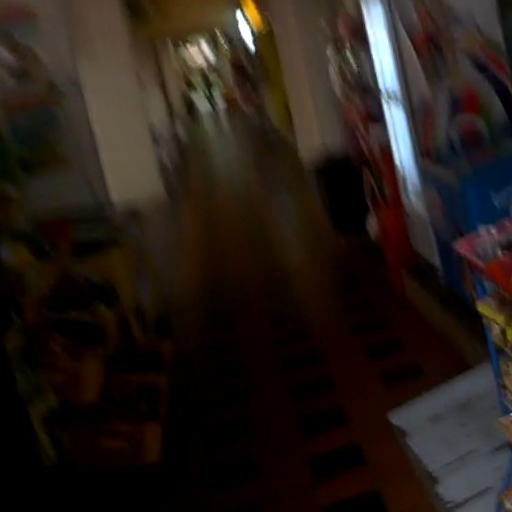

In [184]:
img

In [185]:
import matplotlib.pyplot as plt

unloader = transforms.ToPILImage()
def imshow(tensor, title=None):
    image = tensor.cpu().clone() # we clone the tensor to not do changes on it
    image = image.squeeze(0) # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
        plt.pause(0.001) # pause a bit so that plots are updated

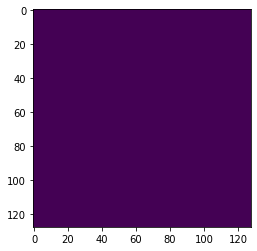

In [186]:
imshow(score_map)

In [176]:
for i in ignored_map.numpy():
    for j in i:
        print(j)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

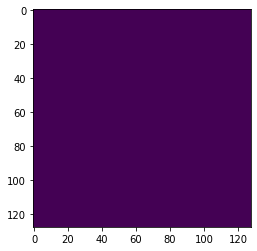

In [177]:
imshow(ignored_map)

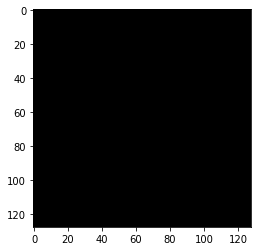

In [178]:
imshow(geo_map)